# Homework 8
This assignment covers Lukas-Kanade tracking method. Please hand in `motion.py` and this notebook file to Gradescope.

In [1]:
# Setup
from __future__ import print_function

import numpy as np
from skimage import filters
from skimage.feature import corner_peaks
import matplotlib.pyplot as plt
from matplotlib import rc
from IPython.display import HTML

%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

## 0. Displaying Video
We have done some cool stuff with static images in past assignemnts. Now, let's turn our attention to videos! For this assignment, the videos are provided as time series of images. We also provide utility functions to load the image frames and visualize them as a short video clip.

*Note: You may need to install video codec like [FFmpeg](http://ffmpeg.zeranoe.com/builds/). For Linux/Mac, you will be able to install ffmpeg using `apt-get` or `brew`. For Windows, you can find the installation instructions [here](https://www.wikihow.com/Install-FFmpeg-on-Windows).*

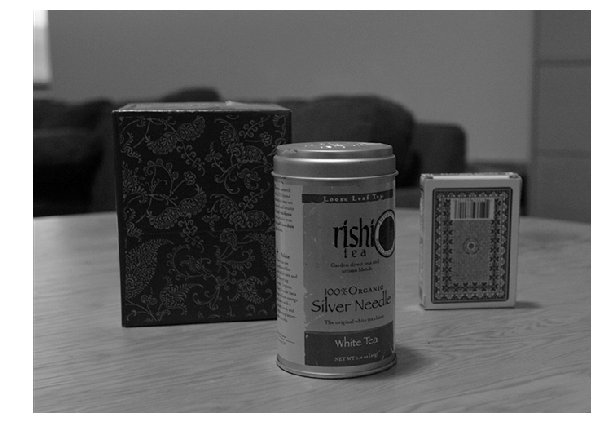

In [2]:
from utils import animated_frames, load_frames
frames = load_frames('images')
ani = animated_frames(frames)
HTML(ani.to_html5_video())

## 1. Lucas-Kanade Method for Optical Flow

### 1.1 Deriving optical flow equation
Optical flow methods are used to estimate motion of objects between two consecutive image frames. For example, in the video above, the can of tea seems to be moving to the left. For our system to be able to understand that the can is moving to the left, it would be useful to find a way to add vectors to the can (known as **flow vectors**) which point to the left, thus describing its motion.

Given two consecutive frames, how can we find the flow vectors for the first frame which describe how objects move between frames? To start, we make a reasonable assumption called the **brightness constancy** assumption: the pixel intensity of a moving point stays the same between two consecutive frames with small time difference. In other words, picking any pixel of the moving can, its brightness stays approximately the same between frames--its movement should not affect its brightness after all.

Consider pixel intensity (a.k.a. brightness) $I(x, y, t)$ of a point $(x, y)$ in the first frame $t$. Suppose that the point has moved to $(x+\Delta{x}, y+\Delta{y})$ after $\Delta{t}$. According to the brightness constancy assumption, we can relate intensities of the point in the two frames using the following equation:

$$
I(x,y,t)=I(x+\Delta{x},y+\Delta{y},t+\Delta{t})
$$

Coming back to the example of the moving can, this equation simply states that the point that we picked will have the same intensity even after it moves in space $(\Delta{x}$ and $\Delta{y})$ and between frames $(\Delta{t})$. From this simple assumption, we can derive what is known as the **optical flow equation**. For a given point for any frame, the optical flow equation is given by:

$$
I_x({\mathbf{p}})v_{x} +
I_y({\mathbf{p}})v_{y} +
I_t({\mathbf{p}})
= 0
$$

Here, $I_x$, $I_y$ and $I_t$ are partial derivatives of pixel intensity $I$. Meanwhile,
$v_{x}$ and $v_{y}$ are **flow vectors** in the $x-$ and $y-$direction, respectively. These are the vectors we care about! If we can solve for these two values, we will be able to describe the motion of any object between frames.

You might be wondering how we went from the brightness constantcy assumption to the optical flow equation. Try to derive it yourself!

- **a.** Derive the optical flow equation from the brightness constancy equation. Clearly state any assumption you make during derivation.


- **b.** Can the optical flow equation be solved given two consecutive frames without further assumption? Which values can be computed directly given two consecutive frames? Which values cannot be computed without additional information?

**Your answer here:** Write your answer in this markdown cell
- **a.**  
Key Assumption:
$$
I(x,y,t)=I(x+\Delta{x},y+\Delta{y},t+\Delta{t})
$$

Linearizing the right side using Taylor expansion:
$$f(x)=\sum\limits_{i=0}^n\frac{f^{(i)}{x_0}}{i!}(x-x_0)^{i}, x\in(x_0-\Delta{x}, x_0+\Delta{x}) $$

$$
I(x+\Delta{x},y+\Delta{y},t+\Delta{t})=I(x,y,t)+I_x*\Delta{x}+I_y*\Delta{y}+I_t
$$
$$
I(x+\Delta{x},y+\Delta{y},t+\Delta{t})-I(x,y,t)=I_x*\Delta{x}+I_y*\Delta{y}+I_t
$$
Hence,
$$
I_x*\Delta{x}+I_y*\Delta{y}+I_t = 0
$$

$$
I_x({\mathbf{p}})v_{x} +
I_y({\mathbf{p}})v_{y} +
I_t({\mathbf{p}})
= 0
$$

- **b.** Optical flow equation cannot be solved given two consecutive frames without further assumption. $I_x({\mathbf{p}})$, $I_y({\mathbf{p}})$, $I_t({\mathbf{p}})$ can be computed directly given two consecutive frames. $v_{x}$, $v_{y}$ cannot be computed without additional information.

### 1.2 Overview of Lucas-Kanade method

One issue with the optical flow equation is that there are two unknowns that we want to solve for ($v_x$ and $v_y$). This problem is known as the **aperture problem**. In other words, just looking an "aperture" at one pixel at a time, it is impossible to discern the true direction of motion of the object in question.

The Lucas–Kanade method solves this problem by adding another assumption: **spatial coherence**. That is, that the motion of the image contents between two frames is approximately constant within a neighborhood of the point $p$ under consideration.

Consider a neighborhood of $p$, $N(p)=\{p_1,...,p_n\}$ (e.g. 3x3 window around $p$). Adding the spatial coherence assumption to the optical flow equation, we see that the following should be satisfied:

For every $p_i \in N(p)$,
$$
I_{x}(p_i)v_x + I_{y}(p_i)v_y = -I_{t}(p_i)
$$

These equations can be written in matrix form $Av=b$, where

$$
A = 
\begin{bmatrix}
    I_{x}(p_1) & I_{y}(p_1)\\
    I_{x}(p_2) & I_{y}(p_2)\\
    \vdots & \vdots\\
    I_{x}(p_n) & I_{y}(p_n)
\end{bmatrix}
\quad
v =
\begin{bmatrix}
    v_{x}\\
    v_{y}
\end{bmatrix}
\quad
b =
\begin{bmatrix}
    -I_{t}(p_1)\\
    -I_{t}(p_2)\\
    \vdots\\
    -I_{t}(p_n)
\end{bmatrix}
$$

We can now solve for the flow vectors (now represented as $v$) by solving the following least-squares problem: $A^{T}Av=A^{T}b$.

- **a.** What is the condition for this equation to be solvable?
- **b.** Reason about why Harris corners might be good features to track using Lucas-Kanade method.

**Your answer here:** Write your answer in this markdown cell
- **a.**   
$A^{T}A$ should be invertible  
$A^{T}A$ should not be too small due to noise  
-- eigenvalues $\lambda_1$ and $\lambda_2$ of $A^{T}A$ should not be too small  
$A^{T}A$ should be well-conditioned  
-- $\lambda_1/\lambda_2$ should not be too large ($\lambda_1$ = larger eigenvalue)

- **b.**  
$A^{T}A$ is the second moment matrix (Harris corner detector)  
$$
A^{T}A = 
\begin{bmatrix}
    \sum{I_xI_x} &  \sum{I_xI_y}\\
    \sum{I_xI_y} &  \sum{I_yI_y}\\
\end{bmatrix} = 
\sum{\begin{bmatrix}
    I_x\\
    I_y
\end{bmatrix}}
\begin{bmatrix}
    I_x
    I_y
\end{bmatrix} =
\sum{\bigtriangledown I(\bigtriangledown I)^{T}}
$$

### 1.3 Implementation of Lucas-Kanade method

In this section, we are going to implement basic Lucas-Kanade method for feature tracking. In order to do so, we first need to find keypoints to track. Harris corner detector is commonly used to initialize the keypoints to track with Lucas-Kanade method. For this assignment, we are going to use [`skimage` implementation](http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_corner.html) of Harris corner detector.

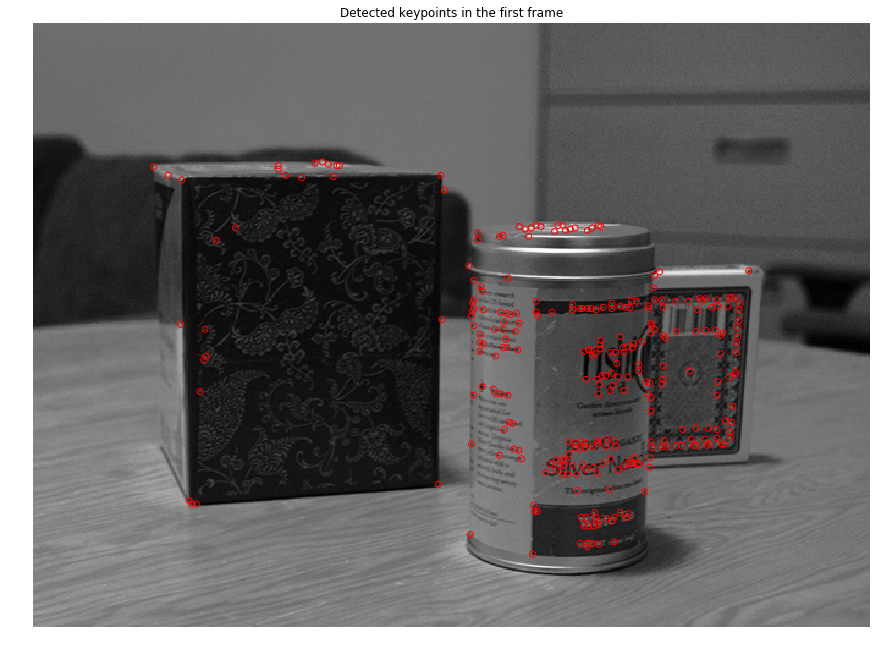

In [3]:
from skimage import filters
from skimage.feature import corner_harris, corner_peaks

frames = load_frames('images')

# Detect keypoints to track
keypoints = corner_peaks(corner_harris(frames[0]),
                         exclude_border=5,
                         threshold_rel=0.01)
# Plot kepoints
plt.figure(figsize=(15,12))
plt.imshow(frames[0])
plt.scatter(keypoints[:,1], keypoints[:,0],
            facecolors='none', edgecolors='r')
plt.axis('off')
plt.title('Detected keypoints in the first frame')
plt.show()

Implement function **`lucas_kanade`** in `motion.py` and run the code cell below. You will be able to see small arrows pointing towards the directions where keypoints are moving.

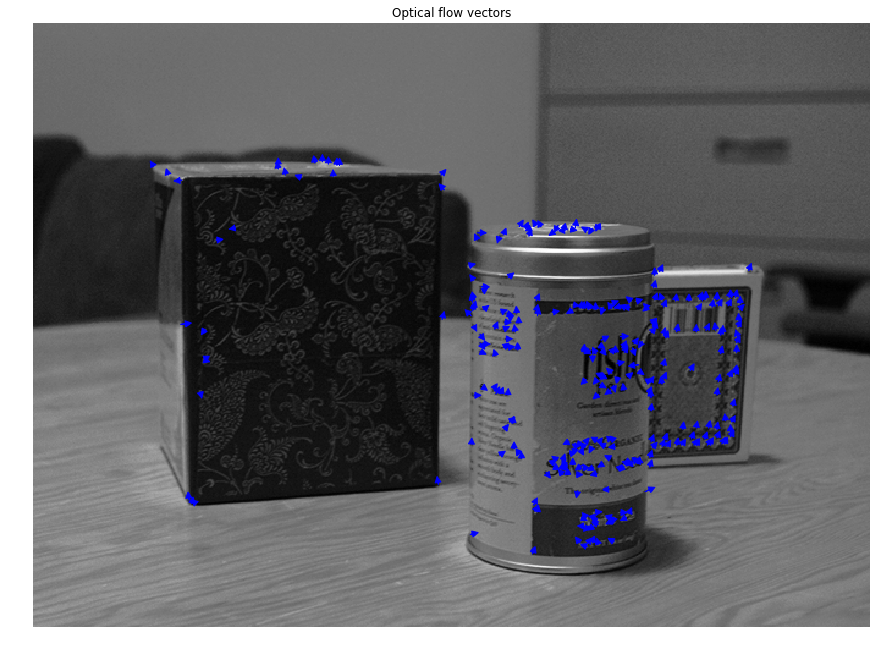

In [4]:
from motion import lucas_kanade

# Lucas-Kanade method for optical flow
flow_vectors = lucas_kanade(frames[0], frames[1], keypoints, window_size=5)

# Plot flow vectors
plt.figure(figsize=(15,12))
plt.imshow(frames[0])
plt.axis('off')
plt.title('Optical flow vectors')

for y, x, vy, vx in np.hstack((keypoints, flow_vectors)):
    plt.arrow(x, y, vx, vy, head_width=5, head_length=5, color='b')
    

We can estimate the position of the keypoints in the next frame by adding the flow vectors to the keypoints.

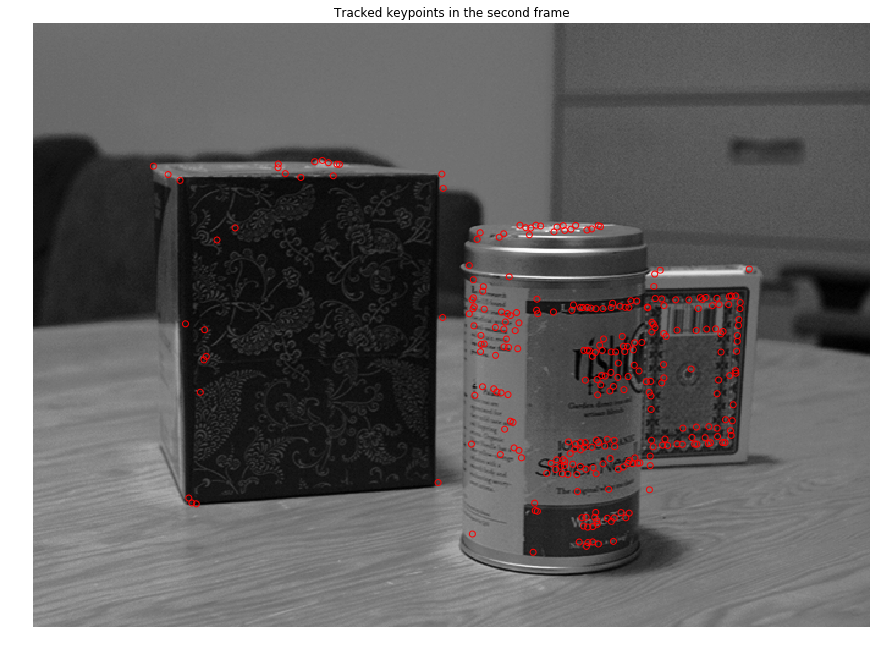

In [5]:
# Plot tracked kepoints
new_keypoints = keypoints + flow_vectors
plt.figure(figsize=(15,12))
plt.imshow(frames[1])
plt.scatter(new_keypoints[:,1], new_keypoints[:,0],
            facecolors='none', edgecolors='r')
plt.axis('off')
plt.title('Tracked keypoints in the second frame')
plt.show()

### 1.4 Feature Tracking in multiple frames
Now we can use Lucas-Kanade method to track keypoints across multiple frames. The idea is simple: compute flow vectors at keypoints in $i$-th frame, and add the flow vectors to the points to keep track of the points in $i+1$-th frame. We have provided the function `track_features` for you. First, run the code cell below. You will notice that some of the points just drift away and are not tracked very well.

Instead of keeping these 'bad' tracks, we would want to somehow declare some points are 'lost' and just discard them. One simple way to is to compare the patches around tracked points in two subsequent frames. If the patch around a point is NOT similar to the patch around the corresponding point in the next frame, then we declare the point to be lost. Here, we are going to use mean squared error between two normalized patches as the criterion for lost tracks.

Implement **`compute_error`** in `motion.py`, and re-run the code cell below. You will see many of the points disappearing in later frames.

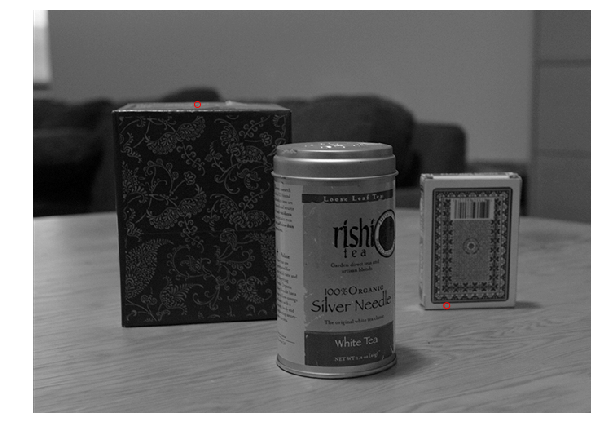

In [6]:
from utils import animated_scatter
from motion import track_features

# Detect keypoints to track in the first frame
keypoints = corner_peaks(corner_harris(frames[0]),
                         exclude_border=5,
                         threshold_rel=0.01)

trajs = track_features(frames, keypoints,
                       error_thresh=1.5,
                       optflow_fn=lucas_kanade,
                       window_size=5)
ani = animated_scatter(frames,trajs)
HTML(ani.to_html5_video())

## 2. Pyramidal Lucas-Kanade Feature Tracker
In this section, we are going to implement a simpler version of the method described in ["Pyramidal Implementation of the Lucas Kanade Feature Tracker"](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.185.585&rep=rep1&type=pdf).

### 2.1 Iterative Lucas-Kanade method
One limitation of the naive Lucas-Kanade method is that it cannot track large motions between frames. You might have noticed that the resulting flow vectors (blue arrows) in the previous section are too small that the tracked keypoints are slightly off from where they should be. In order to address this problem, we can iteratively refine the estimated optical flow vectors. Below is the step-by-step description of the algorithm:

Let $p=\begin{bmatrix}p_x & p_y \end{bmatrix}^T$ be a point on frame $I$. The goal is to find flow vector $v=\begin{bmatrix}v_x & v_y \end{bmatrix}^T$ such that $p+v$ is the corresponding point of $p$ on the next frame $J$.

- Initialize flow vector:
$$
v=
\begin{bmatrix}
    0\\0
\end{bmatrix}
$$

- Compute spatial gradient matrix:
$$
G=\sum_{x=p_x-w}^{p_x+w}\sum_{y=p_y-w}^{p_y+w}
\begin{bmatrix}
    I_{x}^2(x,y) & I_{x}(x,y)I_{y}(x,y)\\
    I_{x}(x,y)I_{y}(x,y) & I_{y}^2(x,y)
\end{bmatrix}
$$

- **for $k=1$ to $K$**
    - Compute temporal difference: $\delta I_k(x, y) = I(x,y)-J(x+g_x+v_x, y+g_y+v_y)$
    - Compute image mismatch vector:
$$
b_k=\sum_{x=p_x-w}^{p_x+w}\sum_{y=p_y-w}^{p_y+w}
\begin{bmatrix}
    \delta I_k(x, y)I_x(x,y)\\
    \delta I_k(x, y)I_y(x,y)
\end{bmatrix}
$$
    - Compute optical flow: $v^k=G^{-1}b_k$
    - Update flow vector for next iteration: $v := v + v^k$


- Return $v$

Implement `iterative_lucas_kanade` method in `motion.py` and run the code cell below. You should be able to see slightly longer arrows in the visualization.

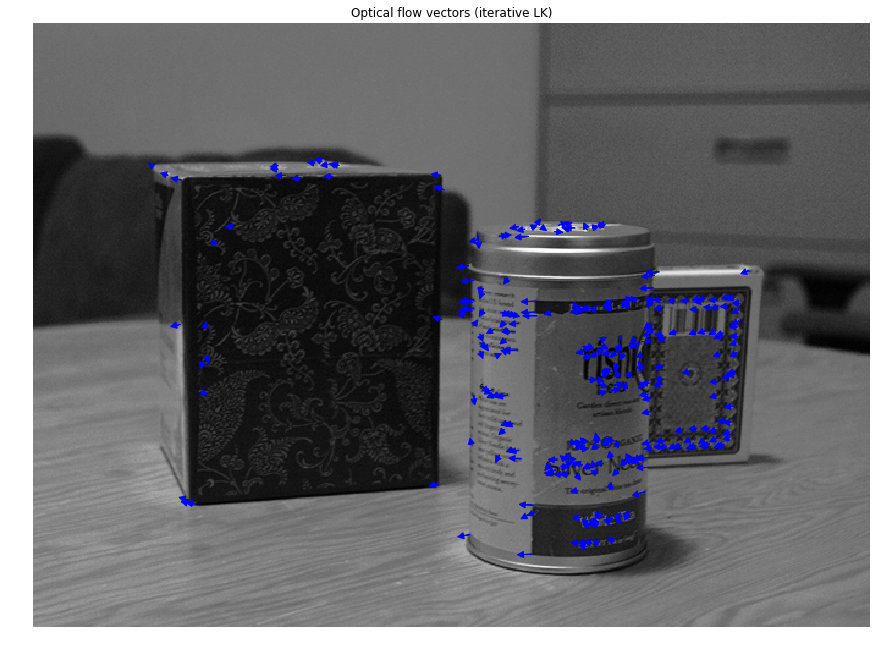

In [12]:
from motion import iterative_lucas_kanade

# Run iterative Lucas-Kanade method
flow_vectors = iterative_lucas_kanade(frames[0], frames[1], keypoints)

# Plot flow vectors
plt.figure(figsize=(15,12))
plt.imshow(frames[0])
plt.axis('off')
plt.title('Optical flow vectors (iterative LK)')

for y, x, vy, vx in np.hstack((keypoints, flow_vectors)):
    plt.arrow(x, y, vx, vy, head_width=5, head_length=5, color='b')

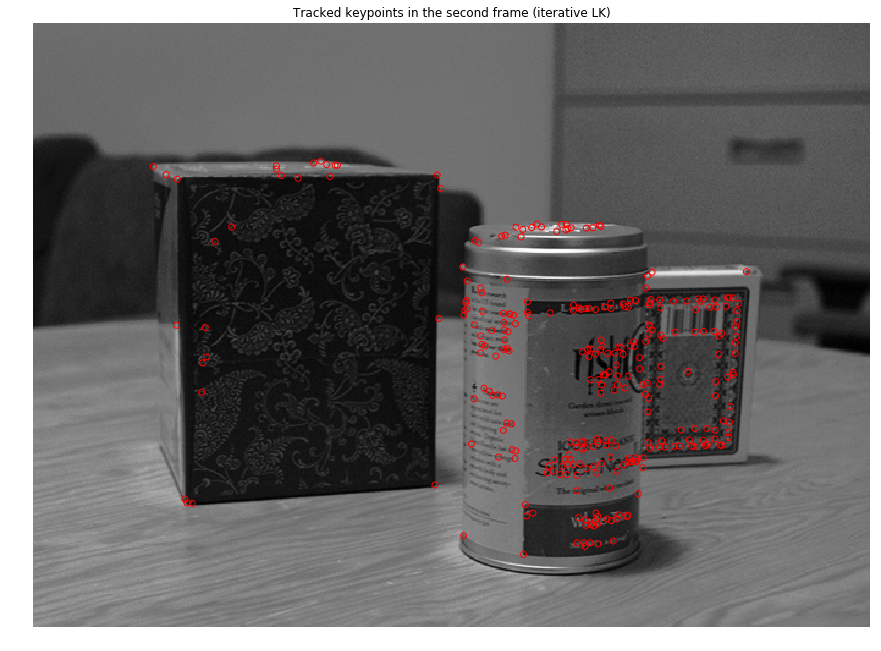

In [13]:
# Plot tracked kepoints
new_keypoints = keypoints + flow_vectors
plt.figure(figsize=(15,12))
plt.imshow(frames[1])
plt.scatter(new_keypoints[:,1], new_keypoints[:,0],
            facecolors='none', edgecolors='r')
plt.axis('off')
plt.title('Tracked keypoints in the second frame (iterative LK)')
plt.show()

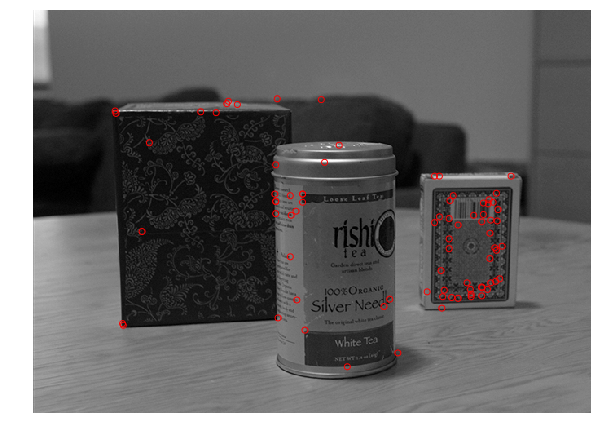

In [14]:
# Detect keypoints to track in the first frame
keypoints = corner_peaks(corner_harris(frames[0]),
                         exclude_border=5,
                         threshold_rel=0.01)

# Track keypoints using iterative Lucas-Kanade method
trajs = track_features(frames, keypoints,
                       error_thresh=1.5,
                       optflow_fn=iterative_lucas_kanade,
                       window_size=5)
ani = animated_scatter(frames,trajs)
HTML(ani.to_html5_video())

### 2.2 Coarse-to-Fine Optical Flow  
#### 效果不好!!! , 跟踪点大量丢失
The iterative method still could not track larger motions. If we downscaled the images, larger displacements would become easier to track. On the otherhand, smaller motions would become more difficult to track as we lose details in the images. To address this problem, we can represent images in multi-scale, and compute flow vectors from coarse to fine scale.

Run the following code cell to visualize image pyramid.

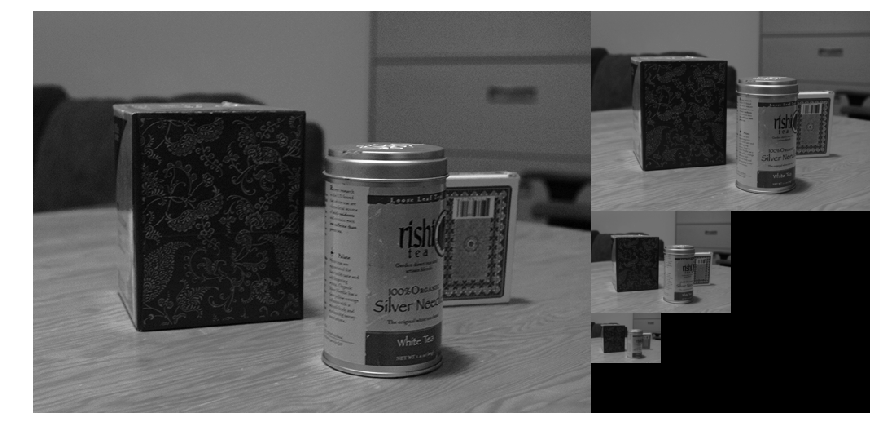

In [53]:
from skimage.transform import pyramid_gaussian

image = frames[0]

# pyramid_gaussian returns tuple of max_layer + 1 images in multiple scales
pyramid = tuple(pyramid_gaussian(image, max_layer=3, downscale=2))

rows, cols = image.shape
composite_image = np.zeros((rows, cols + cols // 2 + 1), dtype=np.double)
composite_image[:rows, :cols] = pyramid[0]

i_row = 0
for p in pyramid[1:]:
    n_rows, n_cols = p.shape
    composite_image[i_row:i_row + n_rows, cols:cols + n_cols] = p
    i_row += n_rows

# Display image pyramid
plt.figure(figsize=(15,12))
plt.imshow(composite_image)
plt.axis('off')
plt.show()

Following is the description of pyramidal Lucas-Kanade algorithm:

Let $p$ be a point on image $I$ and $s$ be the scale of pyramid representation.
- Build pyramid representations of $I$ and $J$: $\{I^L\}_{L=0,...,L_m}$ and $\{J^L\}_{L=0,...,L_m}$


- Initialize pyramidal guess $g^{L_m}=
\begin{bmatrix}g_{x}^{L_m} & g_{y}^{L_m}\end{bmatrix}^T=\begin{bmatrix}0 & 0\end{bmatrix}^T$


- **for $L=L_m$ to $0$ with step of -1**

    - Compute location of $p$ on $I^L$: $p^L=p/s^L$
    
    - Let $d^L$ be the optical flow vector at level $L$:
$$
d^L := IterativeLucasKanade(I^L, J^L, p^L, g^L)
$$
    - Guess for next level $L-1$: $g^{L-1}=s(g^L+d^L)$
    
    
- Return $d=g^0+d^0$

Implement `pyramid_lucas_kanade`.

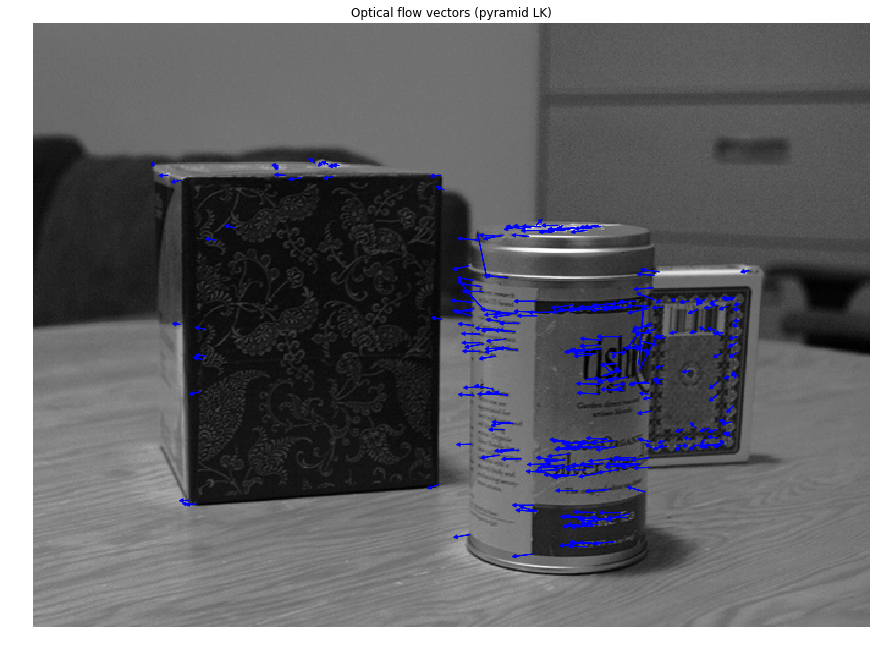

In [58]:
from motion import pyramid_lucas_kanade

# Lucas-Kanade method for optical flow
flow_vectors = pyramid_lucas_kanade(frames[0], frames[1], keypoints)

# Plot flow vectors
plt.figure(figsize=(15,12))
plt.imshow(frames[0])
plt.axis('off')
plt.title('Optical flow vectors (pyramid LK)')

for y, x, vy, vx in np.hstack((keypoints, flow_vectors)):
    plt.arrow(x, y, vx, vy, head_width=3, head_length=3, color='b')

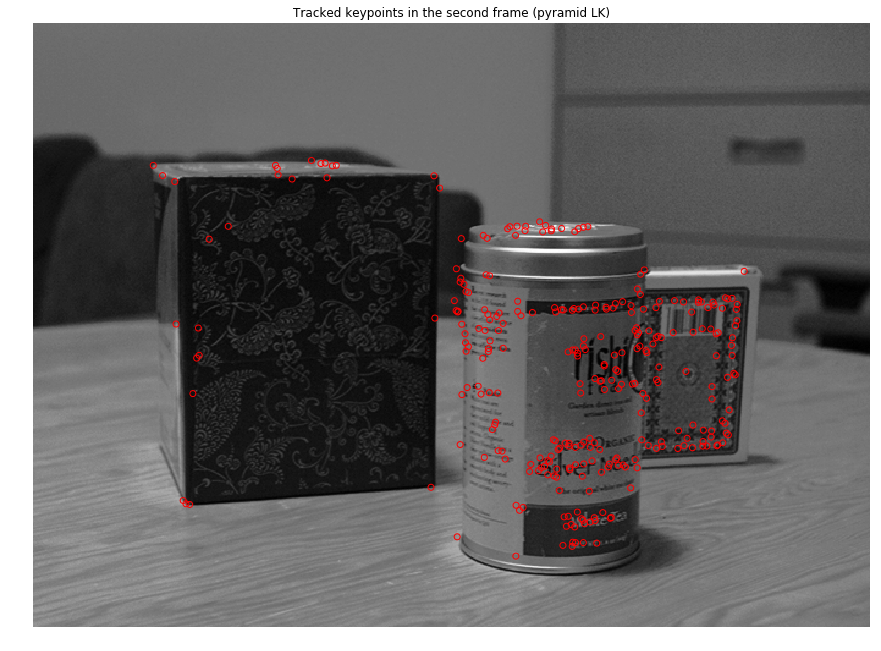

In [59]:
# Plot tracked kepoints
new_keypoints = keypoints + flow_vectors
plt.figure(figsize=(15,12))
plt.imshow(frames[1])
plt.scatter(new_keypoints[:,1], new_keypoints[:,0],
            facecolors='none', edgecolors='r')
plt.axis('off')
plt.title('Tracked keypoints in the second frame (pyramid LK)')

plt.show()

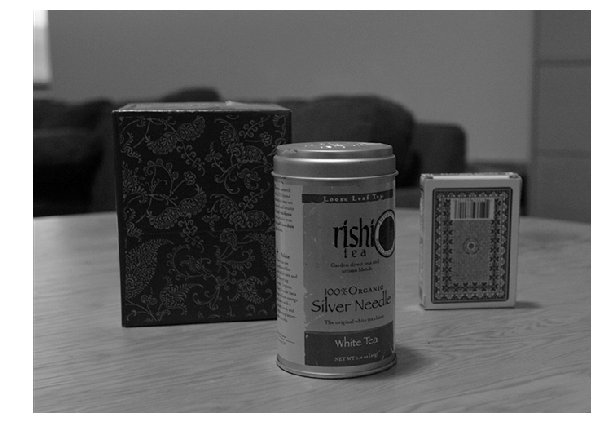

In [60]:
from utils import animated_scatter
from motion import track_features
keypoints = corner_peaks(corner_harris(frames[0]),
                         exclude_border=5,
                         threshold_rel=0.01)

trajs = track_features(frames, keypoints,
                       error_thresh=1.5,
                       optflow_fn=pyramid_lucas_kanade,
                       window_size=5)
ani = animated_scatter(frames,trajs)
HTML(ani.to_html5_video())

## 3. Object Tracking
Let us build a simple object tracker using the Lucas-Kanade method we have implemented in previous sections. In order to test the object tracker, we provide you a short face-tracking sequence. Each frame in the sequence is annotated with the ground-truth location (as bounding box) of face.

An object tracker is given an object bounding box in the first frame, and it has to track the object by predicting bounding boxes in subsequent frames.

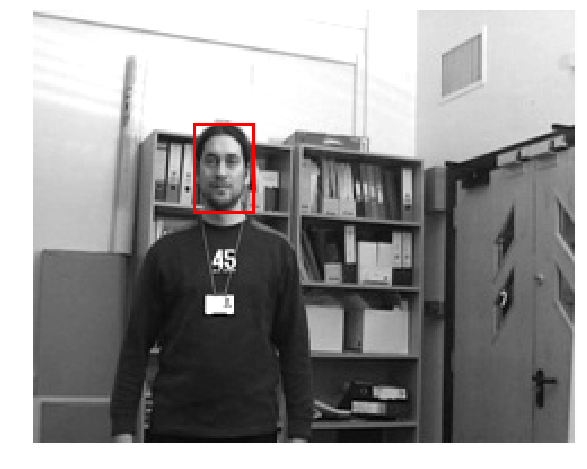

In [61]:
from utils import animated_bbox, load_bboxes

# Load frames and ground truth bounding boxes
frames = load_frames('Man/img')
gt_bboxes = load_bboxes('Man/groundtruth_rect.txt')

ani = animated_bbox(frames, gt_bboxes)
HTML(ani.to_html5_video())

In order to track the object, we first find keypoints to track inside the bounding box. Then, we track those points in each of the following frames and output a tight bounding box around the tracked points. In order to prevent all the keypoints being lost, we detect new keypoints within the bounding box every 20 frames.

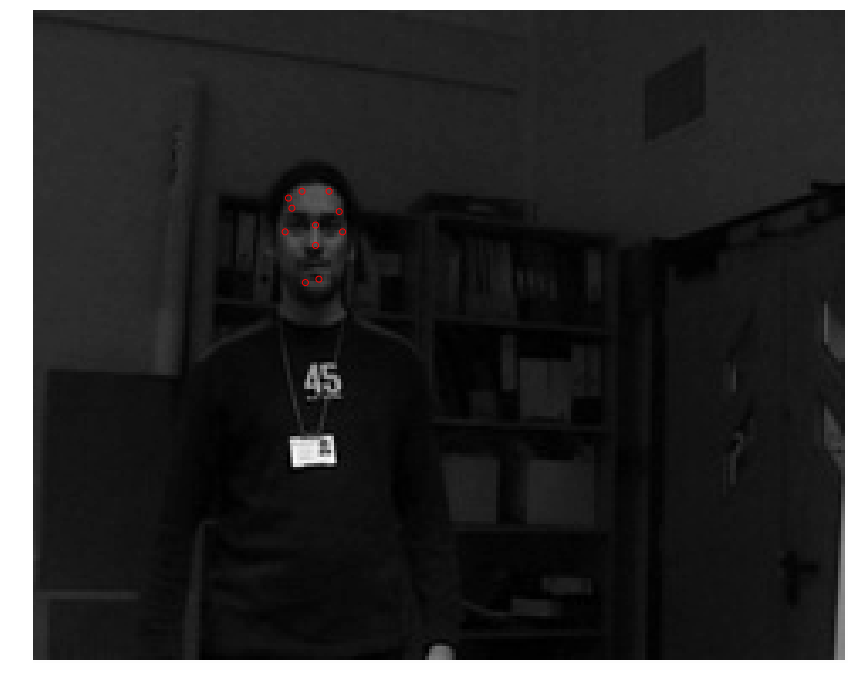

In [67]:
# Find features to track within the bounding box
x, y, w, h = gt_bboxes[0]
roi = frames[0][y:y+h, x:x+w]
keypoints = corner_peaks(corner_harris(roi),
                         exclude_border=3,
                         threshold_rel=0.001)

# Shift keypoints by bbox offset
keypoints[:,1] += x
keypoints[:,0] += y

# Plot kepoints
plt.figure(figsize=(15,12))
plt.imshow(frames[0])
plt.scatter(keypoints[:,1], keypoints[:,0],
            facecolors='none', edgecolors='r')
plt.axis('off')
plt.show()

In [68]:
from motion import compute_error

# Initailze keypoints abd bounding box
kp_I = keypoints
x, y, w, h = gt_bboxes[0]
bboxes = [(x, y, w, h)]

for i in range(len(frames)-1):
    I = frames[i] # current frame
    J = frames[i+1] # next frame
    
    # estimate keypoints in frame J
    #flow_vectors = pyramid_lucas_kanade(I, J, kp_I)
    flow_vectors = iterative_lucas_kanade(I, J, kp_I)
    kp_J = kp_I + flow_vectors
    
    # Leave out lost points
    new_keypoints = []
    for yi, xi, yj, xj in np.hstack((kp_I, kp_J)):
        print(yi, xi, yj, xj)
        if yj > J.shape[0]-2 or yj < 1 or xj > J.shape[1]-2 or xj < 1:
            print('out of bound')
            continue
        else:
            patch_I = I[int(yi)-1:int(yi)+2, int(xi)-1:int(xi)+2]
            patch_J = J[int(yj)-1:int(yj)+2, int(xj)-1:int(xj)+2]
            error = compute_error(patch_I, patch_J)
            if error > 3.0:
                continue
            else:
                new_keypoints.append([yj, xj])
    
    # Update keypoints
    kp_I = np.array(new_keypoints)
    
    # Find bounding box around the keypoints
    if len(kp_I) > 0:
        x = int(kp_I[:,1].min())
        y = int(kp_I[:,0].min())
        w = int(kp_I[:,1].max()) - x
        h = int(kp_I[:,0].max()) - y
    else:
        (x, y, w, h) = (0, 0, 0, 0)
    bboxes.append((x,y,w,h))

    # Refresh keypoints every 20 frames
    if (i+1) % 20 == 0 and (w * h > 0):
        roi = J[y:y+h, x:x+w]
        new_keypoints = corner_peaks(corner_harris(roi),
                                 exclude_border=5,
                                 threshold_rel=0.01)
        new_keypoints[:,1] += x
        new_keypoints[:,0] += y
        kp_I = np.vstack((kp_I, new_keypoints))

53.0 79.0 53.5391257336 79.3147124953
53.0 87.0 52.8702269454 87.4926496375
55.0 75.0 55.0633958218 75.8096996233
58.0 76.0 58.3161346858 76.7168326323
59.0 90.0 59.2281038157 91.0224359395
63.0 83.0 63.0937873963 83.5147019885
65.0 74.0 64.69234368 74.6016615089
65.0 91.0 64.8533564242 91.9177973498
69.0 83.0 68.917742169 83.5004628123
79.0 84.0 79.3061859997 84.8461561006
80.0 80.0 80.3677979489 80.161374011
53.5391257336 79.3147124953 54.2392031712 79.5463524186
52.8702269454 87.4926496375 53.0437499562 87.1011522882
55.0633958218 75.8096996233 54.4694160599 76.2609211784
58.3161346858 76.7168326323 58.1824278985 77.1295420877
59.2281038157 91.0224359395 59.3627669346 91.2961884034
63.0937873963 83.5147019885 62.9363355098 84.9990431865
64.69234368 74.6016615089 65.5616941864 75.1918652598
64.8533564242 91.9177973498 65.5865669157 91.9341222482
68.917742169 83.5004628123 68.6494615352 84.1009900152
79.3061859997 84.8461561006 79.0242834656 85.8769035269
80.3677979489 80.161374011 80

71.3369794879 98.4194736094 71.6211784473 101.045368539
80.4138710649 96.876561882 80.6665137789 100.504677355
83.6372171509 94.8337798449 85.1496542689 98.0207131372
66.0 97.0 66.6408521261 100.394853379
68.0 101.0 68.7390130791 103.703382727
73.0 95.0 73.4998457384 97.663608687
73.0 99.0 74.0419169912 102.381572063
58.7504597527 98.1212776023 60.1578965212 101.432819293
55.0325350652 101.971456012 55.9583846558 105.692816105
55.4676831207 93.5181826162 55.5017388349 97.6898021513
59.5531528838 93.0064428327 61.1861951674 96.2153050085
63.6034761298 105.456665393 64.9591963265 108.230758226
65.8890241611 101.107034536 66.6134468367 104.880222297
70.4307806 89.9626569115 70.3297720025 93.8919063174
68.7721252297 111.235167045 70.3612697326 114.237445805
71.6211784473 101.045368539 73.0666586865 104.681203719
80.6665137789 100.504677355 81.6750194622 104.238939175
85.1496542689 98.0207131372 86.0490186888 101.791193869
66.6408521261 100.394853379 67.4422226732 103.22633601
68.7390130791

73.3963324635 150.971156175 73.0952385309 151.389006787
90.4431854346 148.497717301 89.950479758 148.212610431
70.0181980393 146.929517356 69.8661182525 147.164166572
73.272812255 149.891574379 72.9263164851 150.306403321
80.871405923 147.938314511 81.2717079243 148.183766642
78.5641279904 149.175347861 79.114834787 148.728849564
60.6492493739 148.548504257 60.547496689 149.131248717
65.6963386459 146.692691823 65.7634264513 147.159017677
68.4456888265 153.932431768 68.1563272719 154.379227616
71.5438371303 152.141435624 72.1298097173 151.598062046
75.1157063636 152.05201433 74.6944986975 151.477522452
77.130960308 153.784340897 76.6616817432 154.244168551
65.0628665625 146.18095253 65.0647428378 146.306421373
56.2915254027 155.522737335 55.440078109 156.056886027
61.1794097448 140.704092885 61.4827281194 140.841130281
68.0234148678 141.45919841 67.9790496082 140.592041161
69.0691552504 158.789647734 68.7099106216 158.348540184
68.5537489741 149.727682782 69.3036782163 149.487714121
69

80.2041229776 150.724326488 79.8396986517 150.825237512
61.9308179405 151.494426228 61.5260740234 151.5722536
67.4593489089 147.406306605 67.2868525328 146.68810194
68.9060797119 155.078307311 69.4523866051 154.93309291
74.59981836 152.375264324 75.292298946 152.356366304
73.9920840852 151.894790441 73.642573214 151.832771946
75.8898365953 152.752837725 76.4649476004 152.684893016
66.6467438839 147.486200016 67.3908698779 147.504432931
66.8650776164 160.167210437 67.3026441452 160.229084949
69.1027377512 156.574971644 69.6049027763 156.453693687
72.262589434 153.454074454 71.9380891504 153.375901741
76.942915577 152.192892857 77.5293404507 152.144772112
78.5373166038 152.776456089 79.2162902629 152.856442049
84.1812768656 158.663811067 84.1286001321 158.43768595
86.1591834191 153.617011825 85.8503364263 153.556626026
66.192003121 147.769574705 66.3845028146 147.810735932
60.9387778559 142.853807692 61.0727512648 142.765382548
70.1830890898 141.918660092 69.5845164429 142.051961616
67.9

66.9483021709 149.260162482 66.7576811245 149.018110201
67.6218432647 162.062661134 68.2374578111 161.443091564
69.7245842796 154.08799271 70.2357254615 153.549035194
71.5534655171 155.044764527 72.0354392751 154.264809799
72.6044630147 158.140782949 73.2769122575 157.766379679
72.5253192675 162.233286246 72.6375726186 161.446700961
77.394603271 153.958106272 76.4002079496 153.198954058
78.4530120332 156.01319716 77.5942688548 155.403583314
85.6139055337 154.402820799 85.7026348728 153.734373586
86.5614779943 151.501766341 86.6687111396 151.527377508
87.9261022525 156.487777278 88.4532986651 155.240919556
67.4987525551 148.273635545 67.4987525551 148.273635545
60.5810980776 142.626658375 60.5810980776 142.626658375
71.2609357914 145.957130812 71.2609357914 145.957130812
68.1651784017 163.28187366 68.1651784017 163.28187366
71.5144269067 169.116802482 71.5144269067 169.116802482
74.4735237498 149.381461704 74.4735237498 149.381461704
94.2269399346 152.425070162 94.2269399346 152.4250701

81.6805254944 131.768984361 81.6805254944 131.768984361
76.2601555162 133.693944147 76.2601555162 133.693944147
62.5396764618 134.057143362 62.5396764618 134.057143362
66.6441740904 130.958133669 66.6441740904 130.958133669
69.2424751452 138.942656989 69.2424751452 138.942656989
74.1965033285 136.98682673 74.1965033285 136.98682673
74.4801647538 132.867129718 74.4801647538 132.867129718
76.2580679241 131.608985026 76.2580679241 131.608985026
68.3045131637 127.990709438 68.3045131637 127.990709438
66.7952254941 141.349453995 66.7952254941 141.349453995
68.2589047344 139.735268647 68.2589047344 139.735268647
70.7355981532 133.724148974 70.7355981532 133.724148974
76.5971167084 132.679614553 76.5971167084 132.679614553
81.9420690616 131.301083447 81.9420690616 131.301083447
76.5355460003 157.088841768 76.5355460003 157.088841768
83.0399385022 137.053246512 83.0399385022 137.053246512
66.1164158657 131.580527202 66.1164158657 131.580527202
67.7446640945 139.56623493 67.7446640945 139.56623

74.2009885108 103.652429644 72.8940727819 100.075580964
76.121564451 105.084610423 74.9565604406 100.979024587
77.1349334463 142.979173638 77.2406841088 143.086626264
81.1928881249 143.946301045 81.1578010833 144.081482419
81.9510009938 126.417132441 82.2044121779 125.538669078
81.8164494246 130.893430811 82.0306415809 130.844651764
83.0056797106 134.277256753 83.2395705118 134.156424217
82.9424305515 150.954071439 83.109299975 150.920527217
84.4299031801 143.077533044 84.2082348688 143.056135442
83.9406666937 153.950389842 84.1625822734 153.931636684
63.0763910275 93.367127751 62.8020739177 89.1301065548
56.4821883589 92.7056819701 55.515215365 89.0516332768
68.2091031255 94.6761611704 67.0260862745 91.3889501618
65.6441439649 110.408447806 65.4271294691 106.338107372
70.1097735232 167.711140945 70.0469782762 167.791775554
71.5963293732 99.8080726744 71.6341219011 96.1558410383
92.0577903879 99.1324451435 91.7425742495 95.116576017
71.4873514146 99.1025003291 70.8037657172 94.77217901

90.1266410036 79.3016706497 89.9526497922 77.62977572
69.6323601402 78.8928657402 70.1476623094 78.4034709649
72.5692018272 80.9481408702 73.0334037053 79.5679145471
58.6347917034 80.743700546 59.0103341129 79.3553717065
62.986931117 76.7347674335 62.5748185328 75.8776467134
63.4775739993 91.9191052563 62.7139199581 90.8611387251
66.2675573361 80.6727374367 66.4263384688 80.0144703795
71.7465766116 79.328880388 72.2185824193 77.810659322
73.1117356235 77.1132288928 72.5904253571 75.9834860827
66.4396429579 74.2377380137 66.2178832774 72.5973018011
61.5888091464 83.9674907053 61.6926318775 83.017178291
61.6339505256 88.1737027852 61.6541006586 86.1791847151
65.5284373724 83.1744161371 65.6225180215 81.340849588
72.6607162398 78.1381576945 73.2626790433 76.7279687071
83.7386436411 79.3154649411 84.2120595509 77.4995454178
77.5167958592 157.202924537 78.1898578412 157.031333811
80.9174782036 82.741159661 81.1952023223 81.4723900351
57.6577119355 79.2314614555 58.1202397504 77.5788123037
6

62.0 120.0 61.910757697 120.087295826
62.0 144.0 61.967360074 144.299303117
62.0 149.0 61.9737095676 149.310387733
64.0 82.0 63.7462185346 82.182775674
64.0 85.0 63.8622847203 85.6167995642
65.0 120.0 64.925551521 120.050849921
66.0 97.0 66.2509485353 97.0257114738
67.0 80.0 66.5791159548 80.0967657185
67.0 88.0 67.1051579465 88.6717807532
68.0 83.0 67.5102761645 83.4761214164
68.0 91.0 68.6030197257 91.2436033616
69.0 139.0 68.7803746777 138.963913414
71.0 79.0 70.895764807 80.0178849981
71.0 100.0 70.6748552247 99.9550507104
72.0 107.0 71.9661528578 106.903231045
72.0 125.0 71.9517921831 125.009005577
77.0 92.0 77.4251078793 92.4614186462
77.0 107.0 76.9676021041 107.018394146
77.0 143.0 76.6839770735 142.962004088
79.0 98.0 78.8341478727 97.9691562384
79.0 103.0 78.9758646645 103.070996412
80.0 81.0 80.3975149134 81.067996678
80.0 153.0 79.6639522215 152.88787455
81.0 144.0 80.981054933 144.032096929
82.0 131.0 82.1849565039 130.856602609
83.0 89.0 83.5074456763 89.4540773229
83.0 1

65.477926606 120.270094377 64.7317599303 120.220208839
65.7311991469 98.3273945372 66.2545104501 98.3021196232
68.3490514385 81.518193821 68.3110024962 81.7787073278
67.427931795 91.0716816583 67.1356068621 91.11095501
67.7122919949 83.7124825803 67.6406231733 84.0799795754
70.3110088249 91.3010086962 69.6628328565 91.2143669385
68.6162080953 139.29607456 68.8153304266 139.48820883
70.6061640571 82.0605680861 71.4698253462 82.249534645
70.8568660159 100.387324543 70.9977781803 100.367220887
72.0749286618 107.045424444 72.1818006932 107.211690971
72.322110122 125.037771497 71.7205710426 125.023483517
76.9607130721 92.0566136358 76.7827958744 92.1055225496
76.6385781394 107.062198694 76.7584597024 107.225760181
77.4884936491 143.379344792 76.4512635383 143.476047634
79.2184175779 98.522452544 79.4478234221 98.5364426097
78.5905635225 103.067224597 78.7373859384 103.12776534
79.853122639 82.7475510927 79.9051808295 83.7993887209
78.6056362066 153.414913535 78.810213509 153.367377508
80.70

71.8524102045 81.8890968937 71.8524102045 81.8890968937
71.8790827206 80.8711619272 71.8790827206 80.8711619272
65.8216437137 76.298865505 65.8216437137 76.298865505
62.9167663292 83.3987947519 62.9167663292 83.3987947519
63.3810302301 88.1026891422 63.3810302301 88.1026891422
66.8874571242 83.2012376848 66.8874571242 83.2012376848
71.8414046533 81.7640242534 71.8414046533 81.7640242534
83.8506943581 77.2013148749 83.8506943581 77.2013148749
78.9552591952 157.080099789 78.9552591952 157.080099789
81.0953036909 85.333088931 81.0953036909 85.333088931
60.0904353503 79.886977476 60.0904353503 79.886977476
61.6189556054 88.0005875351 61.6189556054 88.0005875351
65.9732622215 83.3996390798 65.9732622215 83.3996390798
67.9504593413 82.6275584029 67.9504593413 82.6275584029
72.2971213492 122.877109149 72.2971213492 122.877109149
68.4950891146 88.8165286118 68.4950891146 88.8165286118
72.005670539 85.0456768734 72.005670539 85.0456768734
72.0596294677 82.3879315143 72.0596294677 82.3879315143


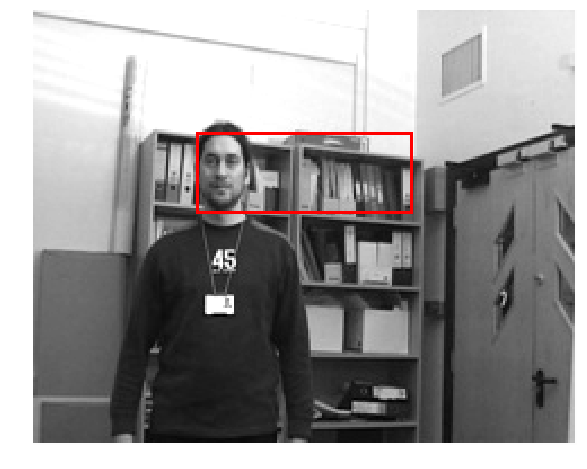

In [69]:
ani = animated_bbox(frames, bboxes)
HTML(ani.to_html5_video())

### 3.1 Evaluating Object Tracker: intersection over union (IoU)
Intersection over union is a common metric for evaluating performance of an object tracker. Implement `IoU` in `motion.py` to evaluate our object tracker. With default parameters, you will get IoU score of ~0.32.

In [71]:
from motion import IoU

average_iou = 0.0
for gt_bbox, bbox in zip(gt_bboxes, bboxes):
    average_iou += IoU(gt_bbox, bbox)
    
average_iou /= len(gt_bboxes)
print(average_iou)

69 48 26 39 69 48 26 39 1.0
70 50 26 39 74 52 17 28 0.46942800788954636
71 50 26 39 75 53 16 27 0.4260355029585799
71 50 26 39 75 52 17 28 0.46942800788954636
71 50 26 39 75 53 18 27 0.47928994082840237
71 50 26 39 75 53 18 27 0.47928994082840237
71 50 26 39 76 53 17 28 0.46942800788954636
71 50 26 39 75 52 18 28 0.4970414201183432
71 50 26 39 75 52 19 29 0.5433925049309665
71 50 26 39 75 52 20 29 0.571992110453649
71 50 26 39 76 52 19 28 0.52465483234714
73 50 26 39 76 52 19 28 0.52465483234714
73 50 26 39 76 53 20 28 0.5522682445759369
73 50 26 39 76 53 21 28 0.5798816568047337
74 50 26 39 77 52 20 29 0.571992110453649
76 50 26 39 77 52 22 29 0.6291913214990138
78 50 26 39 80 53 21 28 0.5798816568047337
77 50 26 39 80 53 21 28 0.5798816568047337
80 50 26 39 81 53 21 29 0.6005917159763313
81 52 26 39 83 52 22 30 0.650887573964497
83 52 26 39 87 53 20 30 0.591715976331361
87 52 26 39 89 55 22 30 0.650887573964497
90 52 26 39 93 55 21 31 0.6420118343195266
91 52 26 39 93 55 21 31 0.6420

## Extra Credit: Optimizing Object Tracker
Optimize object tracker in the code cell below. You may modify the code and define new parameters. We will grant extra credit for IoU score > 0.45.

In [ ]:
from motion import compute_error

### Define your parameters here
### Describe the paramters in comments
error_thresh = 3.0
n_frames = 20


#####################################################
# You may modify the code below to use the params you
# define above.
#####################################################

# Find features to track within the bounding box
x, y, w, h = gt_bboxes[0]
roi = frames[0][y:y+h, x:x+w]
keypoints = corner_peaks(corner_harris(roi),
                         exclude_border=3,
                         threshold_rel=0.001)

# Shift keypoints by bbox offset
keypoints[:,1] += x
keypoints[:,0] += y

# Initailze keypoints and bounding box
kp_I = keypoints
x, y, w, h = gt_bboxes[0]
bboxes = [(x, y, w, h)]

# Start tracking
for i in range(len(frames)-1):
    I = frames[i] # Current frame
    J = frames[i+1] # Next frame
    flow_vectors = pyramid_lucas_kanade(I, J, kp_I) # Compute flow vectors
    kp_J = kp_I + flow_vectors # Estimate keypoints in frame J
    
    new_keypoints = []
    for yi, xi, yj, xj in np.hstack((kp_I, kp_J)):
        # keypoint falls outside the image
        if yj > J.shape[0]-2 or yj < 1 or xj > J.shape[1]-2 or xj < 1:
            print('out of bound')
            continue
        else:
            # Compute error to find lost points
            patch_I = I[int(yi)-1:int(yi)+2, int(xi)-1:int(xi)+2]
            patch_J = J[int(yj)-1:int(yj)+2, int(xj)-1:int(xj)+2]
            error = compute_error(patch_I, patch_J)
            if error > error_thresh:
                continue
            else:
                new_keypoints.append([yj, xj])
    
    # Update keypoints
    kp_I = np.array(new_keypoints)
    
    # Find bounding box around the keypoints
    if len(kp_I) > 0:
        x = int(kp_I[:,1].min())
        y = int(kp_I[:,0].min())
        w = int(kp_I[:,1].max()) - x
        h = int(kp_I[:,0].max()) - y
    else:
        (x, y, w, h) = (0, 0, 0, 0)
    bboxes.append((x,y,w,h))

    # Detect new keypoints every n_frames
    if (i+1) % n_frames == 0 and (w * h > 0):
        roi = J[y:y+h, x:x+w]
        new_keypoints = corner_peaks(corner_harris(roi),
                                 exclude_border=5,
                                 threshold_rel=0.01)
        new_keypoints[:,1] += x
        new_keypoints[:,0] += y
        kp_I = np.vstack((kp_I, new_keypoints))

In [ ]:
from motion import IoU

average_iou = 0.0
for gt_bbox, bbox in zip(gt_bboxes, bboxes):
    average_iou += IoU(gt_bbox, bbox)
    
average_iou /= len(gt_bboxes)
print(average_iou)